In [1]:
import h5py
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class MaskGenerator:
    def _generate_square_mask(self, image_shape, min_square_side=12, max_square_side=22):
        width, height = image_shape[1], image_shape[0]

        mask = np.zeros((height, width), dtype=np.uint8)

        square_side = np.random.randint(min_square_side, max_square_side + 1)

        x = np.random.randint(0, width - square_side)
        y = np.random.randint(0, height - square_side)

        mask[y:y + square_side, x:x + square_side] = 1

        return mask

    def _generate_irregular_mask(self, image_shape, max_radius=14, min_radius=6, points=10):
        width, height = image_shape[1], image_shape[0]

        mask = np.zeros((height, width), dtype=np.uint8)

        x_center = np.random.randint(max_radius, width - max_radius)
        y_center = np.random.randint(max_radius, height - max_radius)

        angles = np.linspace(0, 2 * np.pi, points, endpoint=False)
        radii = np.random.randint(min_radius, max_radius, size=points)
        vertices = [
            (
                int(x_center + radius * np.cos(angle)),
                int(y_center + radius * np.sin(angle))
            )
            for angle, radius in zip(angles, radii)
        ]

        vertices.append(vertices[0])

        polygon = np.array(vertices, dtype=np.int32)
        cv2.fillPoly(mask, [polygon], 1)

        return mask

In [3]:
def save_masks_to_h5(filename, generator_func, image_shape=(224, 224), num_samples=500, batch_size=50):
    with h5py.File(filename, 'w') as h5f:
        h5_dataset = h5f.create_dataset('mask', shape=(num_samples, *image_shape), dtype='uint8')
        for i in tqdm(range(0, num_samples, batch_size), desc=f'Processing {filename}'):
            batch_data = [
                generator_func(image_shape) for _ in range(min(batch_size, num_samples - i))
            ]
            h5_dataset[i:i + len(batch_data)] = batch_data

# Generator instance
generator = MaskGenerator()

# Save square masks
save_masks_to_h5('square.h5', generator._generate_square_mask)

# Save irregular masks
save_masks_to_h5('irregular.h5', generator._generate_irregular_mask)

print('Datasets created successfully in square.h5 and irregular.h5')

Processing irregular.h5: 100%|██████████| 10/10 [00:00<00:00, 85.62it/s]

Datasets created successfully in square.h5 and irregular.h5


In [4]:
def display_mask_from_h5(filename, index=0):
    with h5py.File(filename, 'r') as h5f:
        mask = h5f['mask'][index]
        print(mask.shape)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask from {filename} at index {index}')
        plt.axis('off')
        plt.show()

(224, 224)


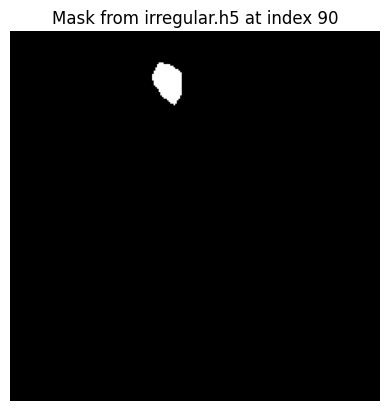

In [5]:
display_mask_from_h5('irregular.h5', index=90)

(224, 224)


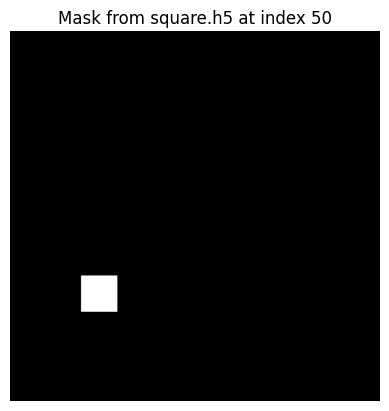

In [6]:
display_mask_from_h5('square.h5', index=50)